In [1]:
import os
import json
import time
import matplotlib.pyplot as plt
from openai import OpenAI
import csv
import pandas as pd

In [2]:
# Constants
MODEL_NAME = "ft:gpt-4o-mini-2024-07-18:defytek-sas:azteca4:AdPOlEt2"
LATENCY_DATASET_PATH = "test_azteca_v1.jsonl"
API_KEY_ENV_VAR = "GIK_OPEN_AI"


In [3]:
# Initialize OpenAI client
def get_openai_client(api_key_env_var):
    api_key = os.getenv(api_key_env_var)
    if not api_key:
        raise ValueError(f"API key not found in environment variable '{api_key_env_var}'")
    return OpenAI(api_key=api_key)

In [10]:
# Test API connection
def test_openai_connection(client):
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {
                    "role": "system",
                    "content": (
                        "Tu nombre es Raúl y trabajas para Cumplir SAS. Tu tarea es comunicarte con los clientes "
                        "con alta empatía y comprensión. Nombre Banco: Banco Azteca. Nombre Cliente: David Cortés. "
                        "Monto Adeudado: 34384 pesos mexicanos. Fecha y hora de hoy: martes 2024-05-28 05:53 PM. "
                        "Días de atraso en el pago: 42. Fecha de pago máxima: miércoles 2024-05-29."
                    ),
                },
                {"role": "user", "content": "bueno"},
            ],
            temperature=0
        )
        print("Connection test successful!")
        print("Model response:", response.choices[0].message.content)
    except Exception as e:
        print(f"Error connecting to OpenAI API: {e}")
        raise


In [5]:
# Load dataset
def load_dataset(filepath):
    try:
        with open(filepath, 'r') as file:
            return [json.loads(line) for line in file]
    except FileNotFoundError:
        raise ValueError(f"Dataset file not found at path: {filepath}")

In [6]:
# Generate context messages for each assistant response
def generate_message_context(messages, assistant_index):
    # Include all prior messages up to and including the last "user" message before the current "assistant"
    context = messages[:assistant_index]
    return context

In [7]:
# Measure latency for each assistant response in all conversations
def measure_latencies(client, conversations):
    all_latencies = []  # Store latencies grouped by conversation
    for idx, conversation in enumerate(conversations):
        conversation_latencies = []  # Store latencies for this conversation
        try:
            messages = conversation['messages']
            for i, msg in enumerate(messages):
                if msg['role'] == 'assistant':
                    context_messages = generate_message_context(messages, i)
                    start_time = time.time()
                    client.chat.completions.create(
                        model=MODEL_NAME,
                        messages=context_messages,
                        temperature=0
                    )
                    latency = time.time() - start_time
                    conversation_latencies.append(latency)
        except Exception as e:
            print(f"Error processing conversation at index {idx}: {e}")
        all_latencies.append(conversation_latencies)  # Append this conversation's latencies
    return all_latencies


In [8]:
# Plot latencies
def plot_latencies_by_conversation(latencies_by_conversation):
    for idx, latencies in enumerate(latencies_by_conversation):
        plt.figure()  # Create a new figure for each conversation
        plt.hist(latencies, bins=7, color='blue', edgecolor='black')
        plt.title(f"Latency Histogram for Conversation {idx + 1}")
        plt.xlabel("Latency (seconds)")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

In [13]:
# Main execution
client = get_openai_client(API_KEY_ENV_VAR)
test_openai_connection(client)

Connection test successful!
Model response: Buenas tardes, ¿me comunico con David Cortés?


Loaded 24 conversations from dataset.


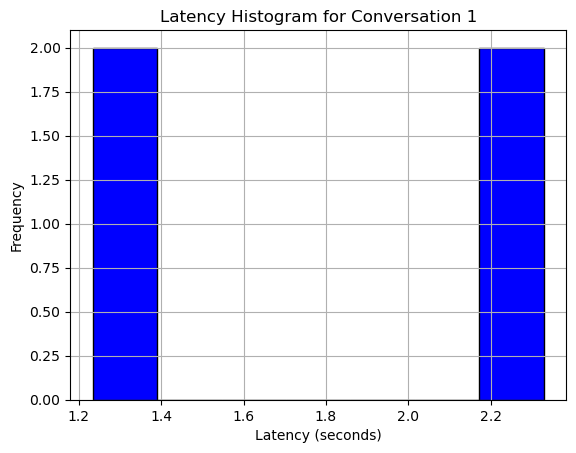

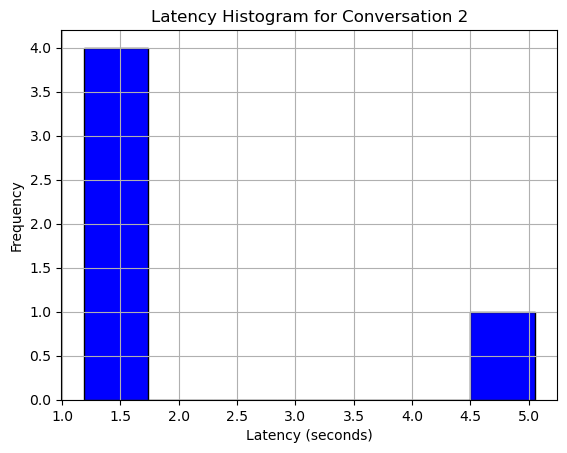

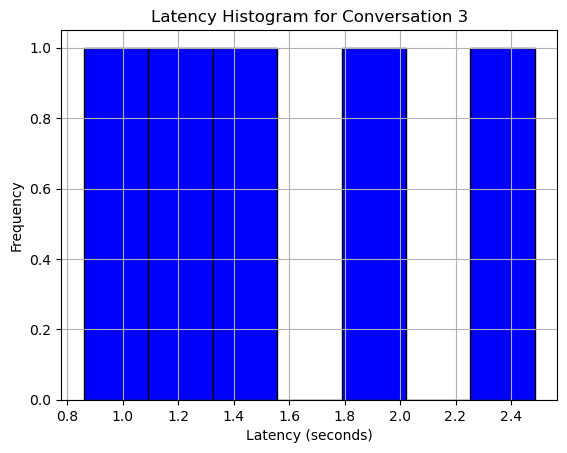

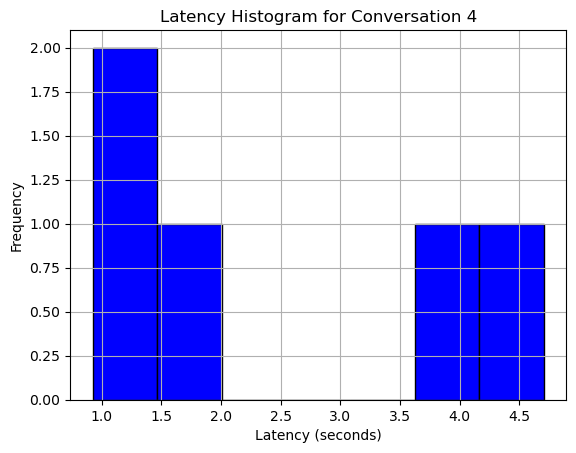

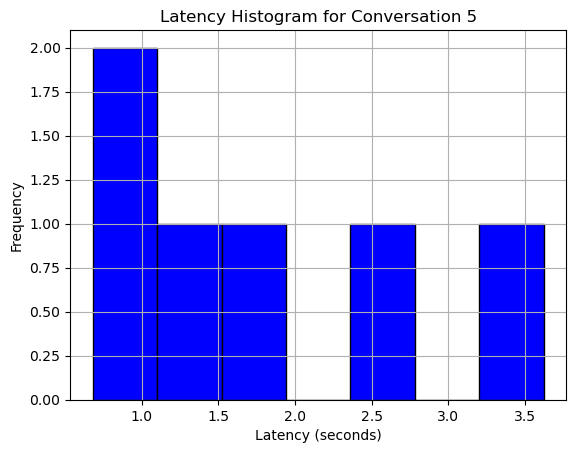

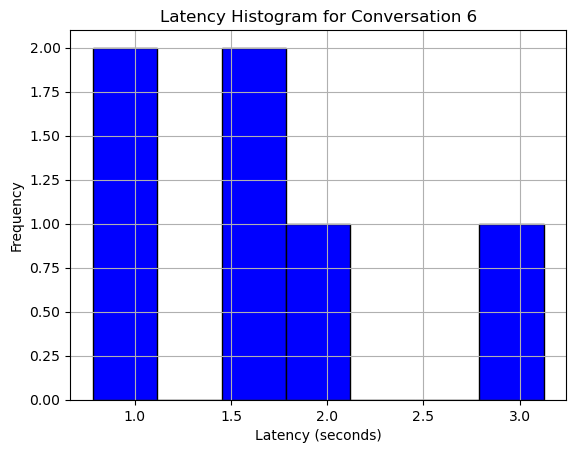

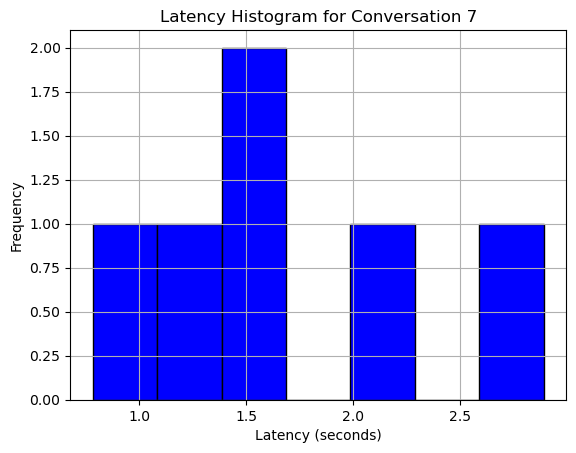

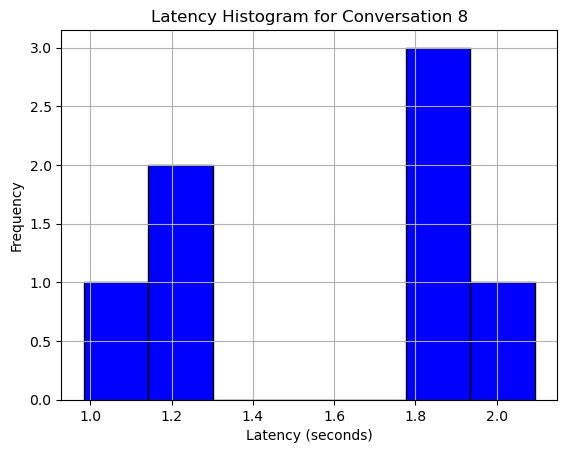

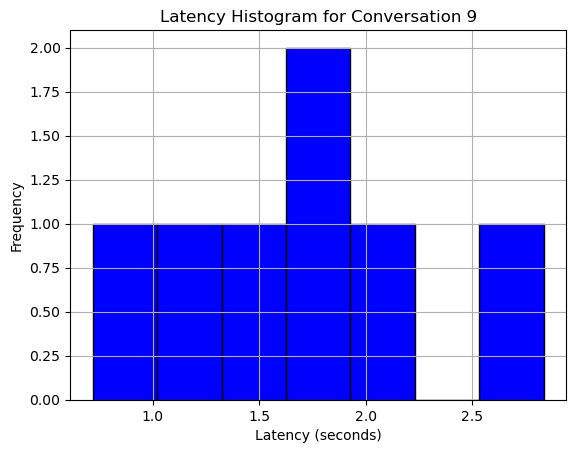

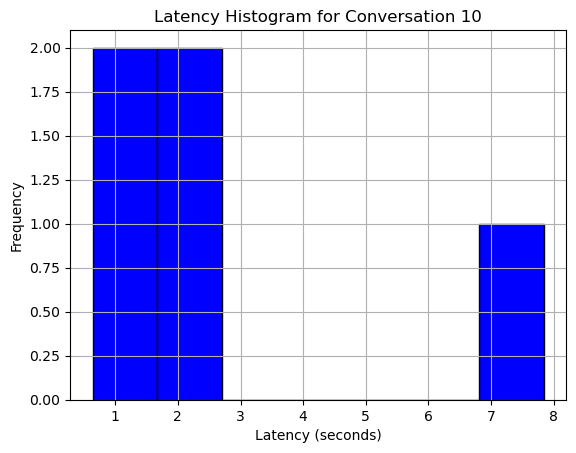

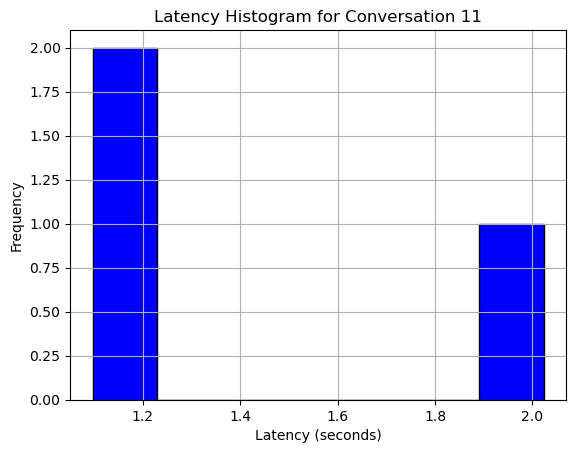

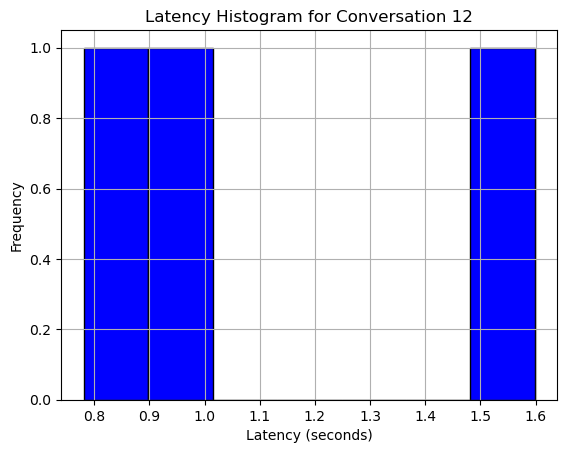

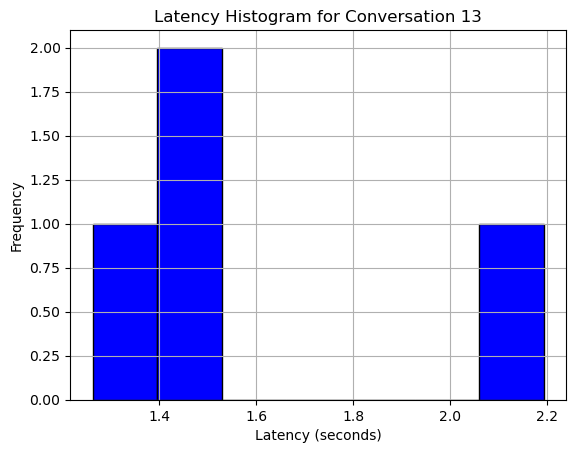

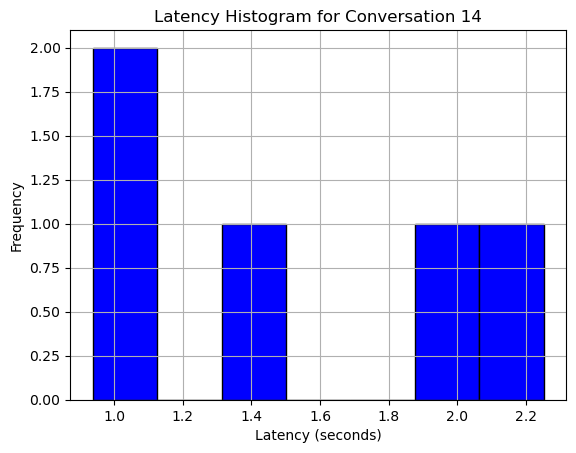

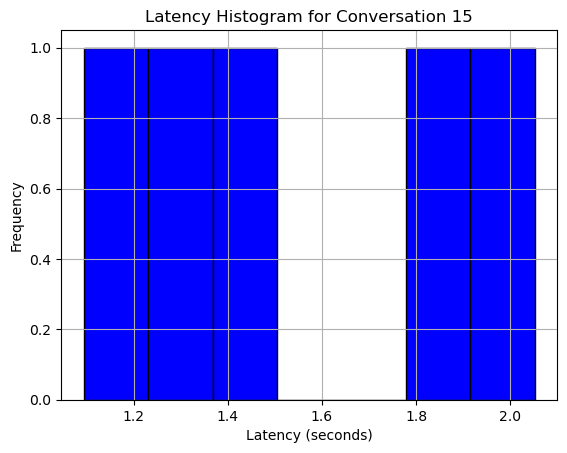

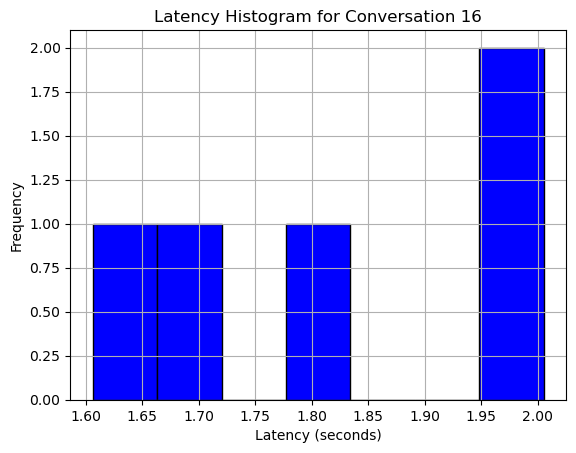

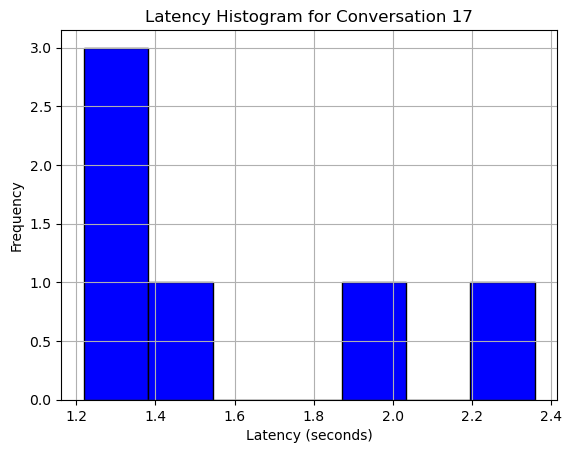

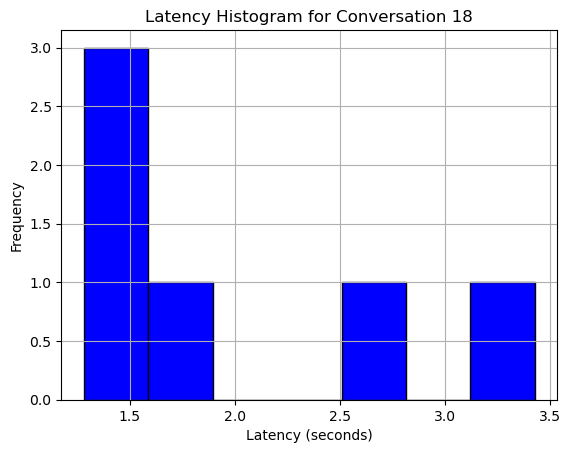

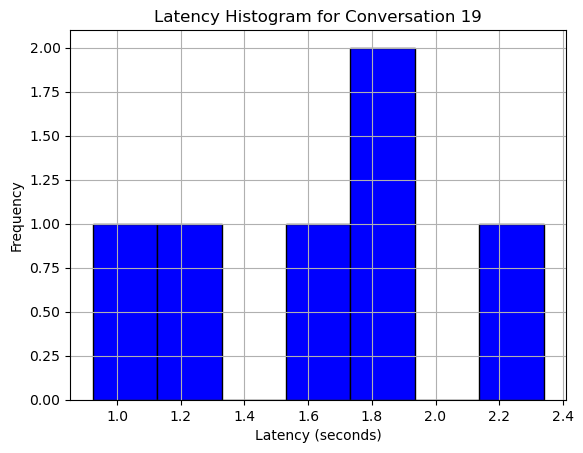

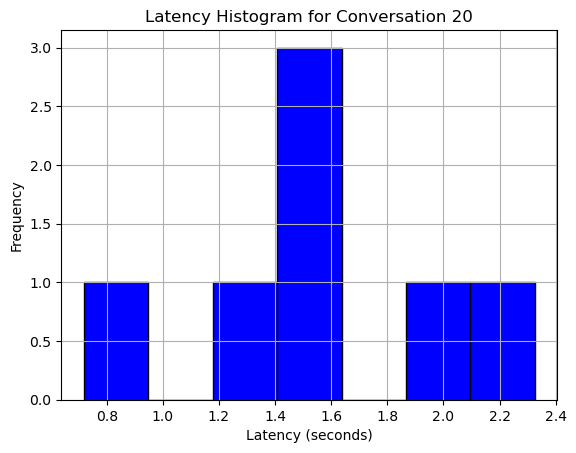

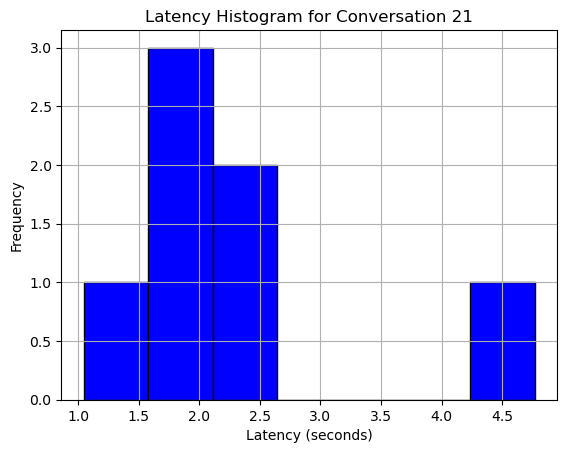

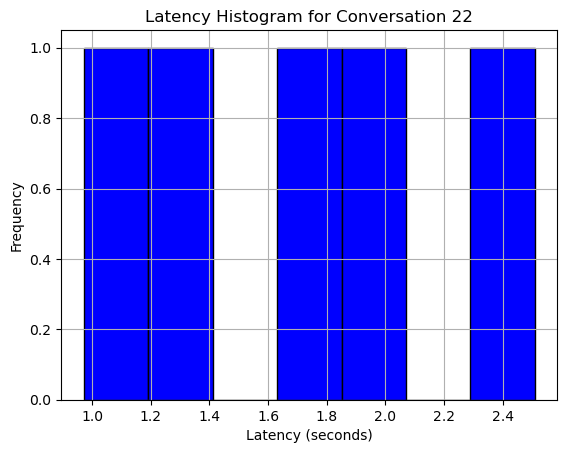

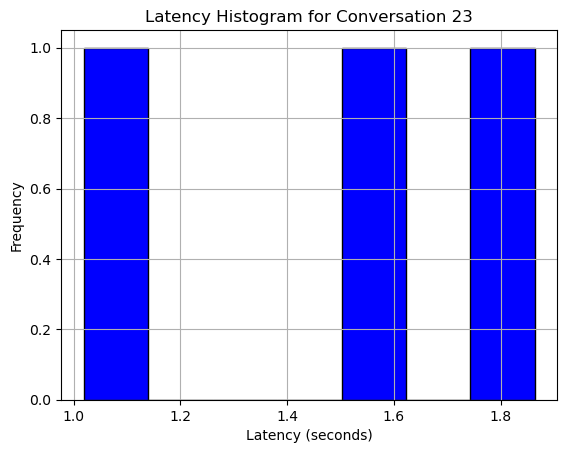

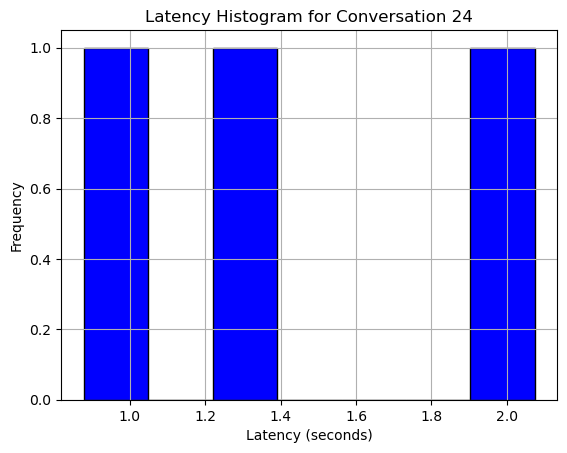

In [14]:
conversations = load_dataset("simulation_modules/test_azteca_v4.jsonl")
print(f"Loaded {len(conversations)} conversations from dataset.")

latencies_by_conversation = measure_latencies(client, conversations)

#Generate separate plots for each conversation
plot_latencies_by_conversation(latencies_by_conversation)


In [15]:
from pprint import pprint

In [16]:
pprint(latencies_by_conversation)

[[1.3132195472717285, 2.3281607627868652, 2.188169479370117, 1.234382152557373],
 [1.4691565036773682,
  5.054469347000122,
  1.3146107196807861,
  1.378282070159912,
  1.1873860359191895],
 [0.8593556880950928,
  2.4862730503082275,
  1.5318806171417236,
  1.1562676429748535,
  1.8419861793518066],
 [1.9708476066589355,
  4.703741550445557,
  3.7220942974090576,
  1.4107773303985596,
  0.9249072074890137],
 [0.6804981231689453,
  3.6216628551483154,
  2.6434099674224854,
  1.6571924686431885,
  1.5018386840820312,
  0.9529728889465332],
 [0.7816472053527832,
  3.1256766319274902,
  2.08933424949646,
  1.5793097019195557,
  0.9250450134277344,
  1.7738537788391113],
 [0.781578779220581,
  2.893629789352417,
  1.4744045734405518,
  1.218742847442627,
  1.5316054821014404,
  2.1474502086639404],
 [0.9843909740447998,
  2.0940945148468018,
  1.8903779983520508,
  1.893634557723999,
  1.9221923351287842,
  1.2656185626983643,
  1.2362112998962402],
 [0.7188029289245605,
  2.834772348403930

In [17]:
# Export latencies to a CSV file
def export_latencies_to_csv(latencies_by_conversation, output_path):
    with open(output_path, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['conversation_index', 'assistant_index', 'latency']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for conv_idx, latencies in enumerate(latencies_by_conversation):
            for assistant_idx, latency in enumerate(latencies):
                writer.writerow({
                    'conversation_index': conv_idx,
                    'assistant_index': assistant_idx,
                    'latency': latency
                })

In [18]:
# Export latencies to a CSV file
output_csv_path = "latencies_temperature_0.csv"
export_latencies_to_csv(latencies_by_conversation, output_csv_path)
print(f"Latencies exported to {output_csv_path}.")

Latencies exported to latencies_temperature_0.csv.


In [19]:
# Load latencies from CSV into a Pandas DataFrame
def load_latencies_csv(file_path):
    return pd.read_csv(file_path)

# Analyze latencies
def analyze_latencies(latencies_df):
    # Basic statistics
    print("Basic Statistics:")
    print(latencies_df['latency'].describe())

    # Latency distribution per conversation
    print("\nAverage Latency Per Conversation:")
    print(latencies_df.groupby('conversation_index')['latency'].mean())

    # Plotting overall latency distribution
    plt.figure(figsize=(8, 6))
    plt.hist(latencies_df['latency'], bins=10, color='blue', edgecolor='black', alpha=0.7)
    plt.title("Overall Latency Distribution")
    plt.xlabel("Latency (seconds)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Latency trends per conversation
    plt.figure(figsize=(10, 6))
    for conversation, group in latencies_df.groupby('conversation_index'):
        plt.plot(group['assistant_index'], group['latency'], marker='o', label=f"Conversation {conversation}")
    plt.title("Latency Trends Per Conversation")
    plt.xlabel("Assistant Response Index")
    plt.ylabel("Latency (seconds)")
    plt.legend()
    plt.grid(True)
    plt.show()

Basic Statistics:
count    124.000000
mean       1.784597
std        0.951651
min        0.640795
25%        1.241955
50%        1.588894
75%        2.048358
max        7.841491
Name: latency, dtype: float64

Average Latency Per Conversation:
conversation_index
0     1.765983
1     2.080781
2     1.575153
3     2.546474
4     1.842929
5     1.712478
6     1.674569
7     1.612360
8     1.694394
9     2.982659
10    1.442840
11    1.111035
12    1.597081
13    1.527951
14    1.513629
15    1.821024
16    1.600675
17    1.986005
18    1.647005
19    1.562029
20    2.274996
21    1.686899
22    1.487066
23    1.417895
Name: latency, dtype: float64


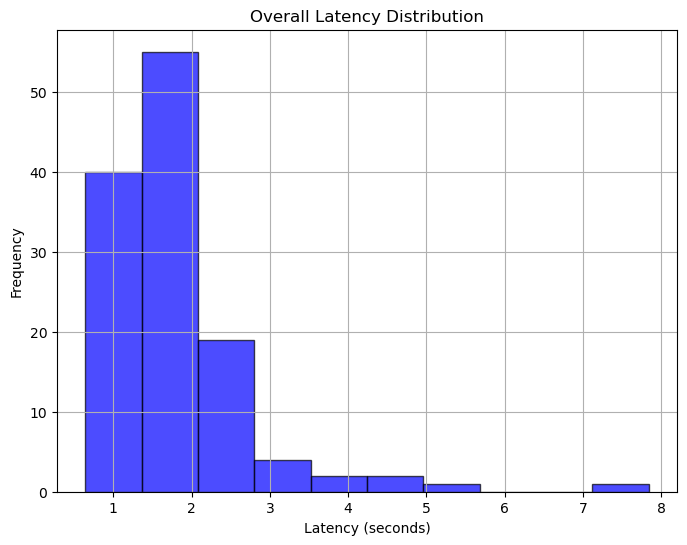

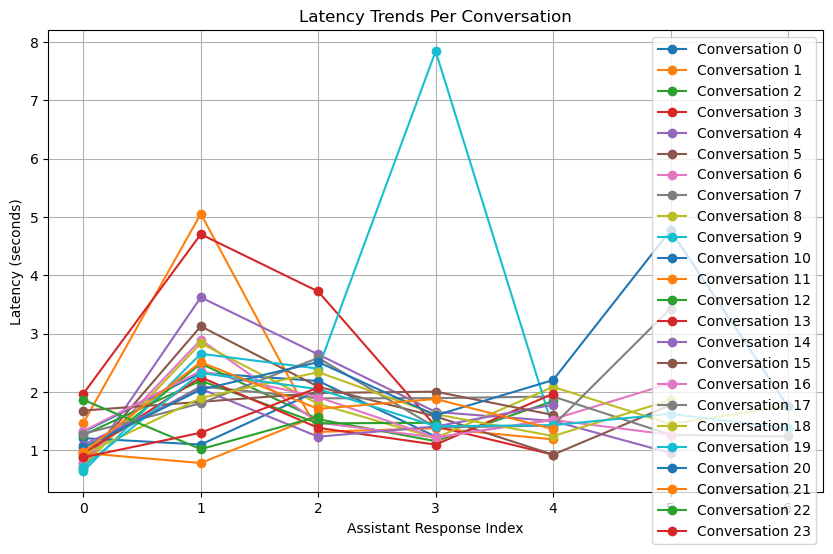

In [20]:
# Main execution
latencies_file = "latencies_temperature_0.csv"  # Path to your latencies CSV file
latencies_df = load_latencies_csv(latencies_file)
analyze_latencies(latencies_df)